# LayoutLMv1 Inference Example

In [ ]:
!sudo apt install -y tesseract-ocr
!pip install pytesseract

## Token Classification/Object Detection

In [5]:
model_id="mrm8488/layoutlm-finetuned-funsd"
processor_id="microsoft/layoutlmv2-base-uncased"

In [6]:
from transformers import AutoTokenizer, LayoutLMForTokenClassification, LayoutLMv2Processor
import torch

model = LayoutLMForTokenClassification.from_pretrained(model_id)
processor = LayoutLMv2Processor.from_pretrained(processor_id)


In [54]:
from PIL import Image

image = Image.open("../assets/invoice_example.png").convert("RGB")
encoding = processor(
    image, return_tensors="pt"
)  # you can also add all tokenizer parameters here such as padding, truncation
del encoding["image"]
print(encoding.keys())

# dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox', 'image'])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox'])


In [62]:
encoding["bbox"]

tensor([[[   0,    0,    0,    0],
         [ 697,   57,  757,   72],
         [ 765,   56,  881,   76],
         [ 892,   57,  960,   72],
         [ 808,  101,  839,  109],
         [ 844,  101,  903,  109],
         [ 907,  101,  960,  109],
         [ 936,  126,  960,  136],
         [ 936,  126,  960,  136],
         [ 910,  151,  960,  161],
         [ 921,  176,  960,  184],
         [  39,  267,   67,  274],
         [  71,  267,   91,  274],
         [  71,  267,   91,  274],
         [ 900,  276,  952,  283],
         [ 900,  276,  952,  283],
         [ 900,  276,  952,  283],
         [ 957,  276,  964,  283],
         [  39,  285,  121,  300],
         [ 129,  285,  179,  296],
         [ 905,  291,  958,  300],
         [ 905,  291,  958,  300],
         [ 905,  291,  958,  300],
         [  38,  309,   91,  322],
         [ 930,  313,  963,  320],
         [  36,  327,   63,  340],
         [ 905,  328,  960,  336],
         [ 905,  328,  960,  336],
         [ 905,  328

In [55]:
outputs = model(**encoding)
predictions = outputs.logits.argmax(-1).squeeze().tolist()

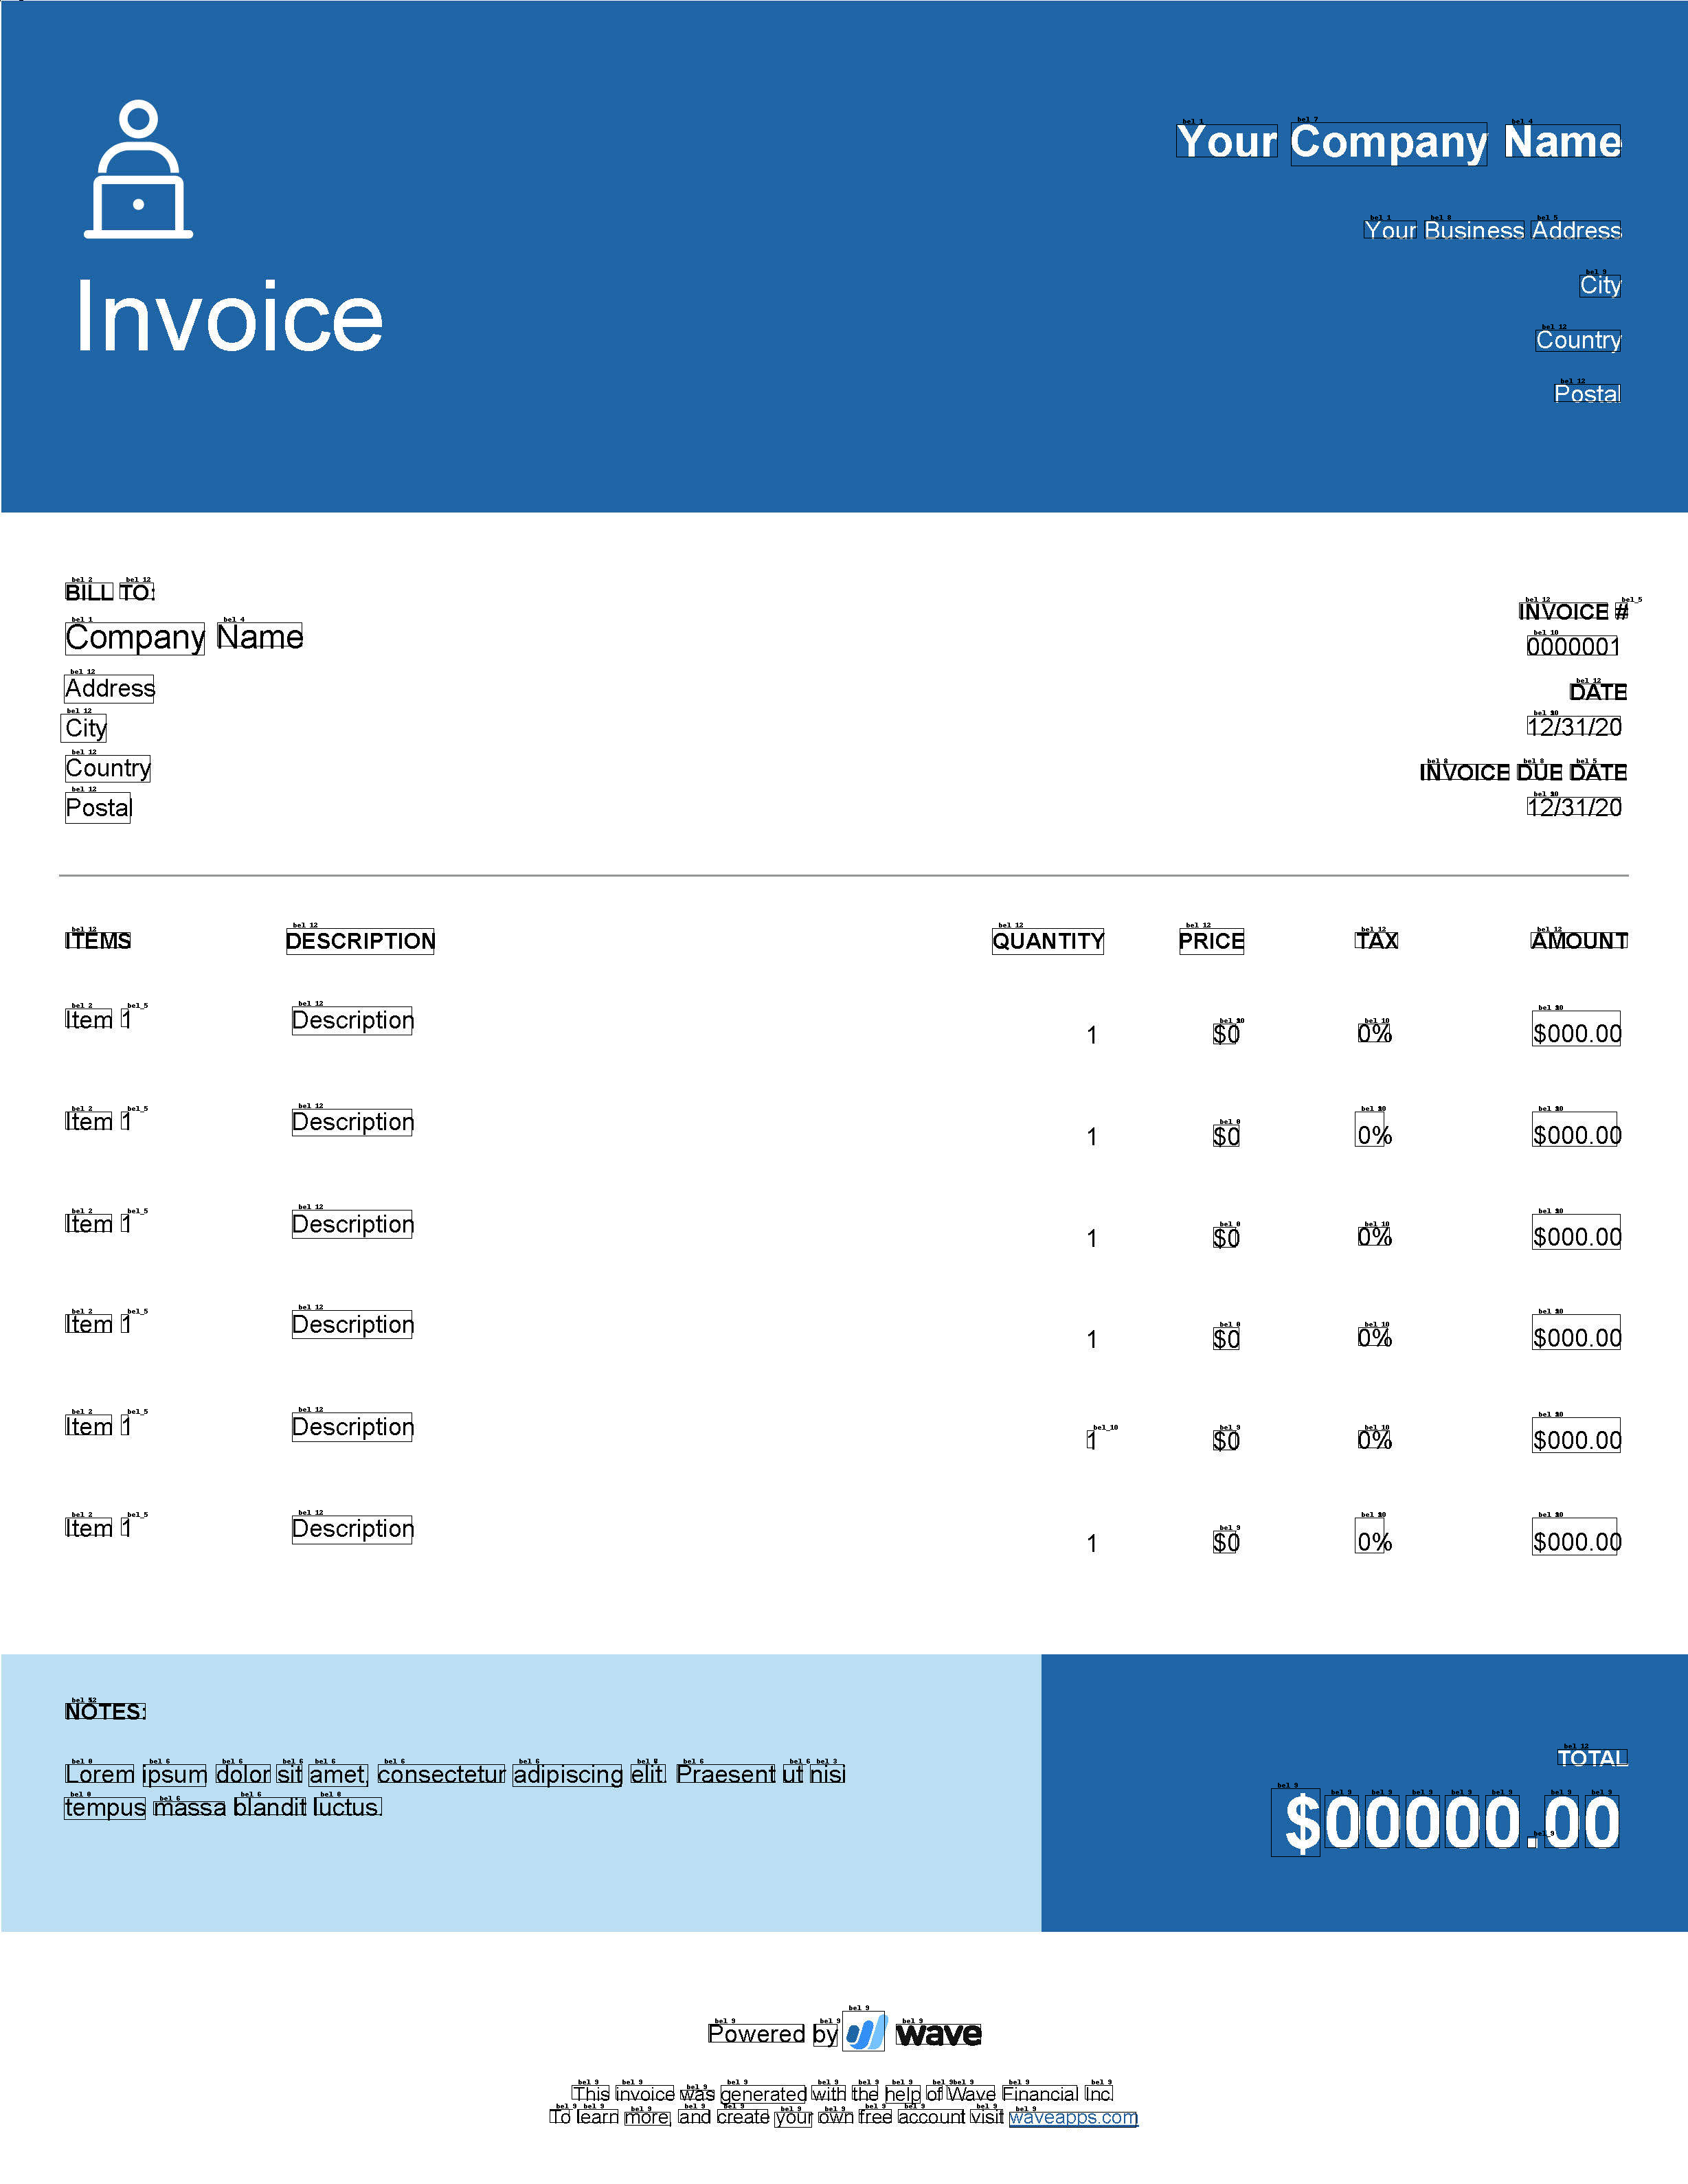

In [60]:
from PIL import Image, ImageDraw, ImageFont


def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label


label_map = {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12"
  }


def postprocess(image,predictions,encoding):
    width, height = image.size
    token_boxes = encoding.bbox.squeeze().tolist()

    # only keep non-subword predictions
    true_predictions = [label_map[str(prediction)] for prediction in predictions]
    true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(token_boxes)]

    # draw predictions over the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(true_predictions, true_boxes):
        predicted_label = iob_to_label(prediction).lower()
        draw.rectangle(box, outline="black")
        # draw.rectangle(box, outline=label2color[predicted_label])
        draw.text((box[0]+10, box[1]-10), text=predicted_label, fill="black", font=font)
        # draw.text((box[0]+10, box[1]-10), text=predicted_label, fill=label2color[predicted_label], font=font)
    
    return image

postprocess(image,predictions,encoding)